In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import imageio

import folium
import folium.plugins
from folium.plugins import MarkerCluster
from ipywidgets import interactive


import tensorflow as tf
from tensorflow import keras

from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn import preprocessing
from sklearn.metrics import log_loss
from sklearn.metrics import make_scorer
from sklearn.model_selection import StratifiedShuffleSplit
from matplotlib.colors import LogNorm
from sklearn.decomposition import PCA
#from keras.layers.advanced_activations import PReLU
#from keras.layers.core import Dense, Dropout, Activation
#from keras.layers.normalization import BatchNormalization
#from keras.models import Sequential
#from keras.utils import np_utils
from copy import deepcopy
%matplotlib inline  

In [2]:
crime = pd.read_csv('/Users/jenniferwu/Documents/BostonCrimeProject/crimes-in-boston/crimetodate_cleaneddata.csv')
crime.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 399636 entries, 0 to 399635
Data columns (total 20 columns):
Unnamed: 0             399636 non-null int64
INCIDENT_NUMBER        399636 non-null object
OFFENSE_CODE           399636 non-null int64
OFFENSE_CODE_GROUP     399636 non-null object
OFFENSE_DESCRIPTION    399636 non-null object
DISTRICT               397816 non-null object
REPORTING_AREA         399636 non-null object
SHOOTING               399636 non-null int64
YEAR                   399636 non-null int64
MONTH                  399636 non-null int64
DAY_OF_WEEK            399636 non-null object
HOUR                   399636 non-null int64
UCR_PART               399527 non-null object
STREET                 397111 non-null object
Lat                    399636 non-null float64
Long                   399636 non-null float64
Location_lat           399636 non-null float64
Location_long          399636 non-null float64
date_occured           399636 non-null object
occured_on_dttm  

# Adding 'Day' and 'Season' Variable

In [3]:
crime['date_day'] = [datetime.strptime(i,"%Y-%m-%d %H:%M:%S").day for i in crime.occured_on_dttm]

In [4]:
def get_season(x):
    if x in [5, 6, 7]:
        r = 'summer'
    elif x in [8, 9, 10]:
        r = 'fall'
    elif x in [11, 12, 1]:
        r = 'winter'
    elif x in [2, 3, 4]:
        r = 'spring'
    return r

In [5]:
crime['season'] = [get_season(i) for i in crime.MONTH]

# Splitting the Train & Test Data for Model

In [6]:
split = np.random.rand(len(crime)) < 0.8
train = crime[split]
test = crime[~split]

In [7]:
print('entire dataset :',len(crime.OFFENSE_CODE_GROUP.value_counts().index), 'offense codes')
print('train dataset :',len(train.OFFENSE_CODE_GROUP.value_counts().index), 'offense codes')
print('test dataset :',len(test.OFFENSE_CODE_GROUP.value_counts().index), 'offense codes')

entire dataset : 67 offense codes
train dataset : 67 offense codes
test dataset : 64 offense codes


In [8]:
train.Lat.replace(-1,None,inplace=True)
train.Long.replace(-1,None,inplace=True)

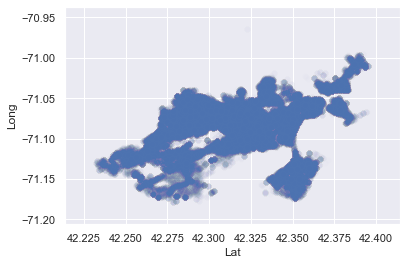

In [9]:
sns.set()
sns.scatterplot(x='Lat',y='Long', data=train, alpha=0.01)
plt.show()

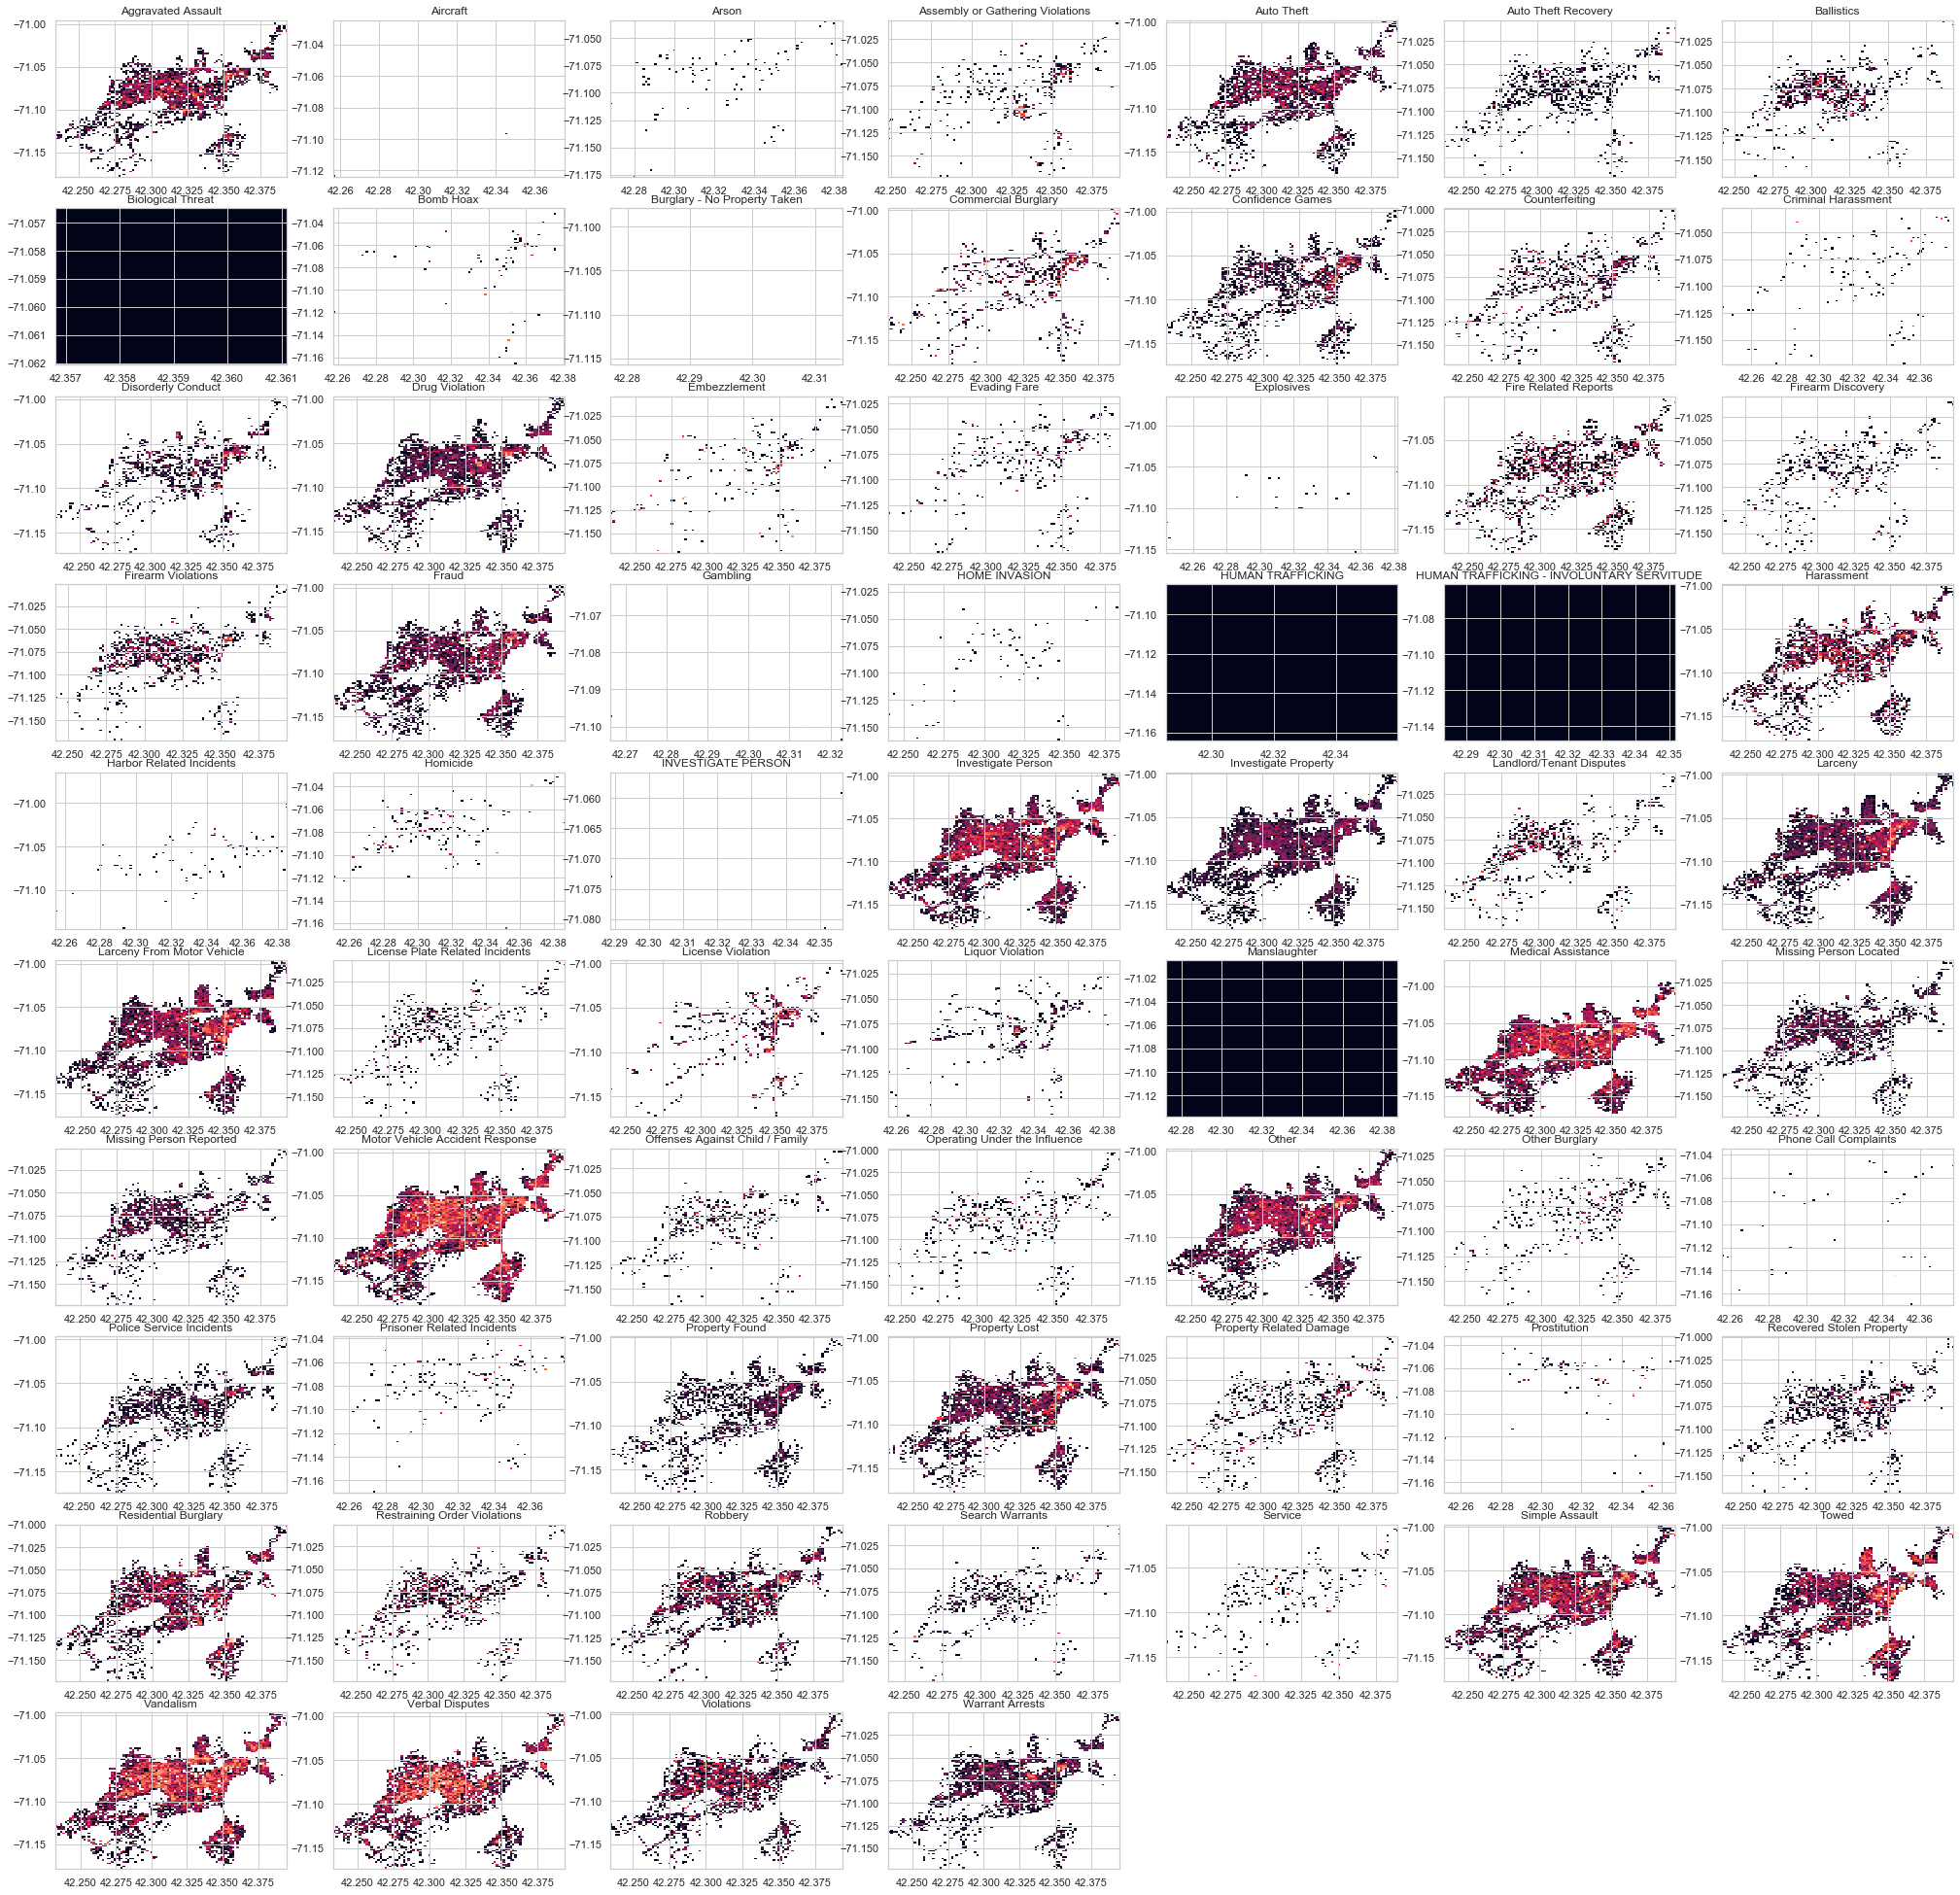

In [10]:
NX=100
NY=100
groups = train.groupby('OFFENSE_CODE_GROUP')
ii=1
plt.figure(figsize=(35, 35))
sns.set_style('whitegrid')
for name, group in groups:
    plt.subplot(10,7,ii)
    histo, xedges, yedges = np.histogram2d(np.array(group.Lat),np.array(group.Long), bins=(NX,NY))
    myextent  =[xedges[0],xedges[-1],yedges[0],yedges[-1]]
    plt.imshow(histo.T,origin='low',extent=myextent,interpolation='nearest',aspect='auto',norm=LogNorm())
    plt.title(name)
    ii+=1
del groups

# Changing the input variable data to prepare for the model

In [11]:
train_clean = train.drop(['UCR_PART','OFFENSE_CODE','OFFENSE_DESCRIPTION','STREET','YEAR','Location_lat','Location_long','occured_on_dttm','date_occured','REPORTING_AREA'], axis = 1)
train_clean.drop(['Unnamed: 0'], axis = 1, inplace = True)
train_clean.head()


,INCIDENT_NUMBER,OFFENSE_CODE_GROUP,DISTRICT,SHOOTING,MONTH,DAY_OF_WEEK,HOUR,Lat,Long,date_day,season
0,I192082859,Auto Theft,E18,0,10,Sunday,9,42.259518,-71.121563,13,fall
2,I192082680,Auto Theft,D14,0,10,Saturday,15,42.352375,-71.135096,12,fall
3,I192082577,Auto Theft,D4,0,10,Saturday,4,42.349476,-71.076402,12,fall
5,I192078648,Investigate Property,B3,0,9,Sunday,6,42.277964,-71.092463,29,fall
7,I192078645,Vandalism,B3,0,9,Sunday,6,42.291816,-71.072441,29,fall


In [12]:
##Categorizing the season column using Dummy Vars : the reason is because there is no Hierarchy..
#meaning that, "Fall IS NOT Higher or Better than Summer"

train_clean_onehot = pd.get_dummies(train_clean, columns=['season'], prefix = [''])
s = (len(list(train_clean_onehot.columns))-len(train_clean.season.value_counts()))
train_clean = pd.concat([train_clean,train_clean_onehot.iloc[:,s:]], axis=1)

##Categorizing the DayOFWeek column using Dummy Vars 
train_clean_onehot = pd.get_dummies(train_clean, columns=['DAY_OF_WEEK'], prefix = [''])
l = (len(list(train_clean_onehot.columns))-len(train_clean.DAY_OF_WEEK.value_counts()))
train_clean = pd.concat([train_clean,train_clean_onehot.iloc[:,l:]],axis=1)

##Categorizing the MONTH column using Dummy Vars : the reason is because there is no Hierarchy..
#meaning that, "FEB IS NOT Higher or Better than JAN"
#This insight was shown from the EDA result (forecasting data with trend might be a different case)

train_clean_onehot = pd.get_dummies(train_clean, columns=['MONTH'], prefix = ['month'])
n = (len(list(train_clean_onehot.columns))-len(train_clean.MONTH.value_counts()))
train_clean = pd.concat([train_clean,train_clean_onehot.iloc[:,n:]],axis=1)

##Categorizing the District column using Dummy Vars 

train_clean_onehot = pd.get_dummies(train_clean, columns=['DISTRICT'], prefix = [''])
o = (len(list(train_clean_onehot.columns))-len(train_clean.DISTRICT.value_counts()))
train_clean = pd.concat([train_clean,train_clean_onehot.iloc[:,o:]],axis=1)

##changing the Output Variables to integer
labels = train_clean['OFFENSE_CODE_GROUP'].astype('category').cat.categories.tolist()
replace_with_int = {'OFFENSE_CODE_GROUP' : {k: v for k,v in zip(labels,list(range(1,len(labels)+1)))}}
train_clean.replace(replace_with_int, inplace=True)

#Normalizing the columns
def norm_func(i):
    r = (i-min(i))/(max(i)-min(i))
    return(r)

train_clean['normHOUR']=norm_func(train_clean.HOUR)
train_clean['normdate_day']=norm_func(train_clean.date_day)
train_clean['normLat']=norm_func(train_clean.Lat)
train_clean['normLong']=norm_func(train_clean.Long)


##removing the unused columns
train_clean.drop(columns = ['season','DAY_OF_WEEK','Lat','Long','HOUR','date_day','MONTH','DISTRICT','INCIDENT_NUMBER'], axis = 1,inplace=True)

In [13]:
train_clean.columns

Index(['OFFENSE_CODE_GROUP', 'SHOOTING', '_fall', '_spring', '_summer',
       '_winter', '_Friday', '_Monday', '_Saturday', '_Sunday', '_Thursday',
       '_Tuesday', '_Wednesday', 'month_1', 'month_2', 'month_3', 'month_4',
       'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10',
       'month_11', 'month_12', '_A1', '_A15', '_A7', '_B2', '_B3', '_C11',
       '_C6', '_D14', '_D4', '_E13', '_E18', '_E5', 'normHOUR', 'normdate_day',
       'normLat', 'normLong'],
      dtype='object')

In [14]:
train_clean.head()

,OFFENSE_CODE_GROUP,SHOOTING,_fall,_spring,_summer,_winter,_Friday,_Monday,_Saturday,_Sunday,...,_C6,_D14,_D4,_E13,_E18,_E5,normHOUR,normdate_day,normLat,normLong
0,5,0,1,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0.391304,0.400000,0.166664,0.266488
2,5,0,1,0,0,0,0,0,1,0,...,0,1,0,0,0,0,0.652174,0.366667,0.737641,0.203342
3,5,0,1,0,0,0,0,0,1,0,...,0,0,1,0,0,0,0.173913,0.366667,0.719817,0.477219
5,33,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0.260870,0.933333,0.280089,0.402273
7,64,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0.260870,0.933333,0.365265,0.495699


## Starting building the neural network model

In [15]:
##Change df into np.arrat since Tensorflow works w array
trainnparray = train_clean.values

TrainData   = trainnparray[:, 1:]
TrainLabels = trainnparray[:, [0]]

TrainLabels = TrainLabels.astype('float32')
TrainData = TrainData.astype('float32')

In [16]:
model = keras.Sequential([
#    keras.layers.Flatten(input_shape=(1, 6)),
    keras.layers.Dense(512, activation=tf.nn.relu),
    keras.layers.Dense(128, activation=tf.nn.relu),
    keras.layers.Dense(68, activation=tf.nn.softmax)
])

model.compile(
              optimizer='adam', 
#              optimizer='sgd', 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.fit(TrainData, TrainLabels, epochs=20)

Train on 319620 samples
Epoch 1/20
319620/319620 [==============================] - 20s 64us/sample - loss: 3.2612 - accuracy: 0.1259
Epoch 2/20
319620/319620 [==============================] - 17s 54us/sample - loss: 3.2231 - accuracy: 0.1308
Epoch 3/20
319620/319620 [==============================] - 18s 56us/sample - loss: 3.2094 - accuracy: 0.1326
Epoch 4/20
319620/319620 [==============================] - 18s 56us/sample - loss: 3.1983 - accuracy: 0.1343
Epoch 5/20
319620/319620 [==============================] - 18s 58us/sample - loss: 3.1881 - accuracy: 0.1362
Epoch 6/20
319620/319620 [==============================] - 18s 57us/sample - loss: 3.1779 - accuracy: 0.1383
Epoch 7/20
319620/319620 [==============================] - 17s 54us/sample - loss: 3.1690 - accuracy: 0.1404
Epoch 8/20
319620/319620 [==============================] - 17s 54us/sample - loss: 3.1612 - accuracy: 0.1425
Epoch 9/20
319620/319620 [==============================] - 18s 57us/sample - loss: 3.1542 - acc

## Train Loss & Accuracy

In [17]:
train_loss, train_acc = model.evaluate(TrainData, TrainLabels)
print('Train Loss:',train_loss,
      'Train accuracy:', train_acc,
       sep = '\n')

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Train Loss:
3.0994503904139394
Train accuracy:
0.1532351


## Test Data Prep

In [18]:
##Categorizing the season column using Dummy Vars : the reason is because there is no Hierarchy..
#meaning that, "Fall IS NOT Higher or Better than Summer"

def data_prep(df):
    
    test_clean = df.drop(['UCR_PART','OFFENSE_CODE','OFFENSE_DESCRIPTION','STREET','YEAR','Location_lat','Location_long','occured_on_dttm','date_occured','REPORTING_AREA'], axis = 1)
    test_clean.drop(['Unnamed: 0'], axis = 1, inplace = True)


    test_clean_onehot = pd.get_dummies(test_clean, columns=['season'], prefix = [''])
    s = (len(list(train_clean_onehot.columns))-len(test_clean.season.value_counts()))
    test_clean = pd.concat([test_clean,test_clean_onehot.iloc[:,s:]], axis=1)

    ##Categorizing the DayOFWeek column using Dummy Vars 
    test_clean_onehot = pd.get_dummies(test_clean, columns=['DAY_OF_WEEK'], prefix = [''])
    l = (len(list(test_clean_onehot.columns))-len(test_clean.DAY_OF_WEEK.value_counts()))
    test_clean = pd.concat([test_clean,test_clean_onehot.iloc[:,l:]],axis=1)

    ##Categorizing the MONTH column using Dummy Vars : the reason is because there is no Hierarchy..
    #meaning that, "FEB IS NOT Higher or Better than JAN"
    #This insight was shown from the EDA result (forecasting data with trend might be a different case)

    test_clean_onehot = pd.get_dummies(test_clean, columns=['MONTH'], prefix = ['month'])
    n = (len(list(test_clean_onehot.columns))-len(test_clean.MONTH.value_counts()))
    test_clean = pd.concat([test_clean,test_clean_onehot.iloc[:,n:]],axis=1)

    ##Categorizing the District column using Dummy Vars 

    test_clean_onehot = pd.get_dummies(test_clean, columns=['DISTRICT'], prefix = [''])
    o = (len(list(test_clean_onehot.columns))-len(test_clean.DISTRICT.value_counts()))
    test_clean = pd.concat([test_clean,test_clean_onehot.iloc[:,o:]],axis=1)

    ##changing the Output Variables to integer
    labels = test_clean['OFFENSE_CODE_GROUP'].astype('category').cat.categories.tolist()
    replace_with_int = {'OFFENSE_CODE_GROUP' : {k: v for k,v in zip(labels,list(range(1,len(labels)+1)))}}
    test_clean.replace(replace_with_int, inplace=True)

    #Normalizing the columns
    def norm_func(i):
        r = (i-min(i))/(max(i)-min(i))
        return(r)

    test_clean['normHOUR']=norm_func(test_clean.HOUR)
    test_clean['normdate_day']=norm_func(test_clean.date_day)
    test_clean['normLat']=norm_func(test_clean.Lat)
    test_clean['normLong']=norm_func(test_clean.Long)


    ##removing the unused columns
    test_clean.drop(columns = ['season','DAY_OF_WEEK','Lat','Long','HOUR','date_day','MONTH','DISTRICT','INCIDENT_NUMBER'], axis = 1,inplace=True)
    return(test_clean)

In [19]:
test_clean = data_prep(test)
test_clean.head()

,OFFENSE_CODE_GROUP,SHOOTING,_Friday,_Monday,_Saturday,_Sunday,_Thursday,_Tuesday,_Wednesday,month_1,...,_C6,_D14,_D4,_E13,_E18,_E5,normHOUR,normdate_day,normLat,normLong
1,5,0,0,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0.869565,0.366667,0.996936,0.000883
4,5,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0.347826,0.033333,0.999696,0.001598
6,29,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0.130435,0.933333,0.999370,0.001607
10,29,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0.043478,0.933333,0.999501,0.002026
13,30,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,1,0.173913,0.933333,0.997548,0.000753


In [20]:
##Change df into np.arrat since Tensorflow works w array
testnparray = test_clean.values

TestData   = testnparray[:, 1:]
TestLabels = testnparray[:, [0]]

TestLabels = TrainLabels.astype('float32')
TestData = TrainData.astype('float32')

In [21]:
model = keras.Sequential([
#    keras.layers.Flatten(input_shape=(1, 6)),
    keras.layers.Dense(512, activation=tf.nn.relu),
    keras.layers.Dense(128, activation=tf.nn.relu),
    keras.layers.Dense(68, activation=tf.nn.softmax)
])

model.compile(
              optimizer='adam', 
#              optimizer='sgd', 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.fit(TestData, TestLabels, epochs=20)

Train on 319620 samples
Epoch 1/20
319620/319620 [==============================] - 19s 61us/sample - loss: 3.2611 - accuracy: 0.1256
Epoch 2/20
319620/319620 [==============================] - 16s 51us/sample - loss: 3.2237 - accuracy: 0.1304
Epoch 3/20
319620/319620 [==============================] - 17s 52us/sample - loss: 3.2106 - accuracy: 0.1327
Epoch 4/20
319620/319620 [==============================] - 17s 54us/sample - loss: 3.1996 - accuracy: 0.1338
Epoch 5/20
319620/319620 [==============================] - 17s 53us/sample - loss: 3.1895 - accuracy: 0.1362 - loss: 3.1894 - accuracy
Epoch 6/20
319620/319620 [==============================] - 17s 54us/sample - loss: 3.1801 - accuracy: 0.1386
Epoch 7/20
319620/319620 [==============================] - 17s 53us/sample - loss: 3.1704 - accuracy: 0.1401
Epoch 8/20
319620/319620 [==============================] - 17s 53us/sample - loss: 3.1636 - accuracy: 0.1422
Epoch 9/20
319620/319620 [==============================] - 17s 54us/s

In [22]:
test_loss, test_acc = model.evaluate(TestData, TestLabels)
print('Test Loss:', test_loss,
      'Test Accuracy:',test_acc,
       sep = '\n')

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Test Loss:
3.0994803352862004
Test Accuracy:
0.15402353


### It is good that test has lower loss or roughly similar to train loss. This indicates that there are no overfitting and that the train data might be more complicated so there is higher loss.

In [225]:
#Now Exporting the predictions

predictions = model.predict(TestData)
predictions = predictions 
predictiondata=pd.DataFrame(data=predictions) 
predictiondata.drop([0], axis =1, inplace = True) #removing the 0th class auto created by TF
predictiondata.rename(columns = {i:j for i,j in zip(predictiondata.columns,labels)}, inplace = True)
predictiondata['MaxProb'] = [np.max(i) for i in predictions]

In [ ]:
#predictiondata.to_csv('/Users/jenniferwu/Documents/BostonCrimeProject/crimes-in-boston/prediction_data.csv'
#                      ,encoding='utf-8', index=False)

In [2]:
#predictiondata = pd.read_csv('/Users/jenniferwu/Documents/BostonCrimeProject/crimes-in-boston/prediction_data.csv')